In [153]:
from pathlib import Path
import sys
from collections import defaultdict
import torch
from torch.utils.tensorboard.writer import SummaryWriter
from rl_envs.grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
# from agents.DQN import DeepQLearningAgent
from agents.DQN_exact_book import DeepQLearningAgent
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:


def print_actions(agent, env, get_optimal = False):
    with torch.no_grad():
        # action_mapping = [" ↓ "," ↑ "," → "," ← "," ↺ "]
        for i in range(env.height):
            print("[", end=" ")
            for j in range(env.width):
                state = agent.state_normalize((i,j), env.height, env.width)
                # state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                action = agent.get_action(state)
                print(env.action_mappings[action], end=" ")
            print("]")

# def state_normalize(state, height, width):
#     # normalize each to [0,1]
#     return (state[0]/(height-1),state[1]/(width-1))




BATCHSIZE = 100
LEARN_RATE = 0.001 # change to 0.001
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],         
]
DISCOUNTED_FACTOR = 0.9

def calculate_state_value_error(env:GridWorldEnv,agent):
    # offline policy have 2 policies, I am using the behavior(random) policy for calculating
    with torch.no_grad():
        state_value_error = 0
        V = {}
        for i in range(env.height):
            for j in range(env.width):
                state = torch.tensor(agent.state_normalize((i,j), env.height, env.width), dtype=torch.float).unsqueeze(0)
                state_value = 0
                for action_ind in range(agent.action_space):
                    action = torch.tensor(action_ind/(agent.action_space-1), dtype=torch.float).view(-1,1)
                    sa_pair = torch.cat([state,action], dim=1)
                    q_value = agent.policy_net(sa_pair)
                    state_value += q_value.item() * (1.0/env.possible_actions)
                state_value_error += abs(state_value - TRUE_RANDOM_STATE_VALUE[i][j])
                V[(i,j)] = state_value
    return state_value_error, V




In [155]:

env = GridWorldEnv(5, 5, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=-1, hit_wall_reward=-1, target_reward=1)
agent = DeepQLearningAgent(input_dim=3, output_dim=1, action_space=env.possible_actions, lr = LEARN_RATE, discounted_factor=DISCOUNTED_FACTOR)
writer = SummaryWriter()



In [156]:
"""
generate samples to replay buffer
"""


replay_buffer = ReplayMemory(2000)

for _ in range(10):
    state = env.reset()
    for _ in range(200):
        action = random.randint(0,4)
        next_state, reward = env.step(state, action)
        action = float(action)  / env.possible_actions # action also normalzie into [0,1]
        replay_buffer.push(torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float), torch.tensor(action, dtype=torch.float).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float))
        state = next_state



In [ ]:
"""
perform DQN
"""
C = 5000 # 0-50 感觉都差不多, 可能 15 更好 (但是或许是太小了, 反而 100-500 的模式或许才是对的) 1000>500?
# for C in [5]:
# for C in [1,2,3,5,8,13,21,34,50,80,100,200,300,500]:
iter_counter = 0
# log_name = 'LR_{}_C_{}'.format(LEARN_RATE, C)
# writer = SummaryWriter(log_dir = 'runs/'+log_name)
for _ in range(50000):
    # for _ in range(50):
    transitions  = replay_buffer.sample(BATCHSIZE)
    batch = Transition(*zip(*transitions))
    state = torch.stack(batch.state)
    next_state = torch.stack(batch.next_state)
    reward = torch.cat(batch.reward)
    action_indices = torch.cat(batch.action)

    loss, q_value, target_value = agent.update_Q_network(state, action_indices, reward, next_state)
    # copy target network every C=5 iteration
    # state_value_estimated = output.sum(dim=1) / env.possible_actions 
    with torch.no_grad():
        writer.add_scalar('TD error', (abs(q_value - target_value)).sum(), iter_counter)         
        writer.add_scalar('Loss', loss.sum(), iter_counter)
        writer.add_scalar('State value error', calculate_state_value_error(env,agent)[0], iter_counter)
        iter_counter+=1
    if iter_counter % C == 0:
    # agent.target_net.load_state_dict(agent.policy_net.state_dict())
        agent.sync_target_network()
        print_actions(agent, env, True)
        print(iter_counter)
    # print(loss)

writer.flush()
writer.close()
print_actions(agent, env, True)
print()

KeyboardInterrupt: 

In [ ]:
print(env)

print_actions(agent, env, True)

print()

# for i in range(env.height):
#     print("[", end=" ")
#     for j in range(env.width):
#         state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
#         output = agent.policy_net(state)
#         state_value = output.sum()/env.possible_actions
#         state_value_error = (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
#         print(state_value_error, end=" ")
#     print("]")


[ 0.000000 0.000000 0.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 0.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 1.000000 -1.000000 0.000000 ]
[ 0.000000 -1.000000 0.000000 0.000000 0.000000 ]

[  ↺   ↺   ↺   ↺   ↺  ]
[  ↺   ↑   ↑   ↑   ↓  ]
[  ↑   ↑   ↑   ↑   ↑  ]
[  ↑   ↑   ↑   ↑   ↑  ]
[  ↑   ↑   ↑   ↑   ↺  ]



In [ ]:
Q = defaultdict(lambda: [0 for _ in range(agent.action_space)])
for i in range(env.height):
    for j in range(env.width):
        state = torch.tensor(agent.state_normalize((i,j), env.height, env.width), dtype=torch.float).unsqueeze(0)
        for action_ind in range(agent.action_space):
            action = torch.tensor(action_ind/(agent.action_space-1), dtype=torch.float).view(-1,1)
            sa_pair = torch.cat([state,action], dim=1)
            q_value = agent.policy_net(sa_pair)
            Q[(i,j)][action_ind] = q_value.item()
print_by_dict(env,Q)
                                                                                                                                                                                                                     
                                 

[ [124.00950622558594, 123.8915786743164, 124.08917999267578, 124.30864715576172, 124.56246185302734] [123.74972534179688, 123.87974548339844, 124.07735443115234, 124.27497100830078, 124.4718246459961] [123.8282470703125, 124.04877471923828, 124.07524108886719, 124.2163314819336, 124.42743682861328] [123.83356475830078, 124.35889434814453, 124.29443359375, 124.21609497070312, 124.36876678466797] [123.78672790527344, 124.19623565673828, 124.4452896118164, 124.3669662475586, 124.64281463623047] ]
[ [124.15901947021484, 124.00686645507812, 124.20448303222656, 124.41915130615234, 124.55375671386719] [124.32379913330078, 123.99504089355469, 124.13114929199219, 124.22396850585938, 124.3167953491211] [124.56959533691406, 124.14332580566406, 124.06500244140625, 124.0296859741211, 124.12250518798828] [124.46915435791016, 124.21907806396484, 124.21587371826172, 124.13753509521484, 124.05921173095703] [124.30341339111328, 124.1883316040039, 124.32097625732422, 124.28839874267578, 124.272735595703

In [ ]:
state_error_sum, V = calculate_state_value_error(env,agent)
print(state_error_sum)
print()
print_by_dict(env, V)

3188.714944458008

[ 124.17 124.09 124.12 124.21 124.29 ]
[ 124.27 124.20 124.19 124.22 124.27 ]
[ 124.11 124.06 124.04 124.12 124.19 ]
[ 123.85 123.84 123.88 123.95 124.00 ]
[ 123.70 123.68 123.76 123.81 123.79 ]


In [ ]:
V = {}
for state in Q.keys():
    V[state] = max(Q[state])
print_by_dict(env, V)


[ 124.56 124.47 124.43 124.37 124.64 ]
[ 124.55 124.32 124.57 124.47 124.32 ]
[ 124.35 124.31 124.32 124.38 124.52 ]
[ 124.32 124.35 124.11 124.10 124.24 ]
[ 124.13 124.22 124.22 124.03 123.98 ]


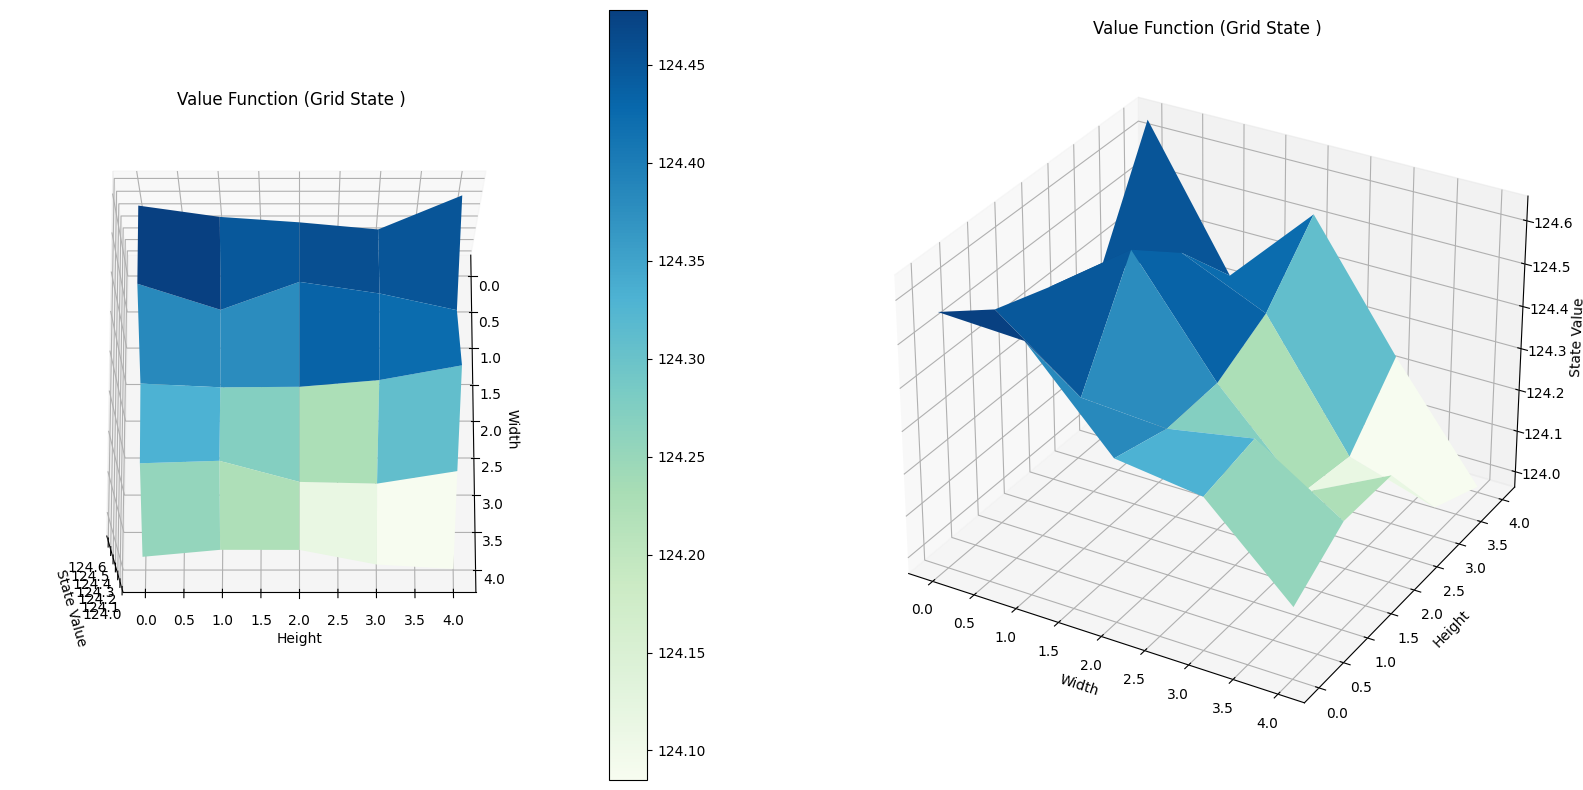

In [ ]:
plot_value_function(V)